## 01 下载数据集&导入库
MNIST 手写数字数据集（下载地址及相关介绍：http://yann.lecun.com/exdb/mnist/ ）

In [101]:
import os
from tqdm import tqdm
# 保存数据的目录
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torch.nn import functional as F

%matplotlib inline
import matplotlib.pyplot as plt

data_dir = './MNIST/raw'
os.makedirs(data_dir, exist_ok=True)
print("\nFiles in directory './MNIST':")
for file_name in os.listdir(data_dir):
    print(file_name)


Files in directory './MNIST':
t10k-images-idx3-ubyte
t10k-labels-idx1-ubyte
train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz
train-images-idx3-ubyte.gz
train-labels-idx1-ubyte.gz
train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz


## 02 数据集&模型框架

In [102]:
# 2.1 FUNC: load data into 2 DataLoader
def load_data(data_dir,bs=32,mode_show=0):
    # PIPE：Image transformation pipeline. Each element in the list is a transformation operation
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.5,),std=(0.5,)) # normalized_image = (image - mean) / std
    ])
    # train_data & test_data：
    train_data = torchvision.datasets.MNIST(root=data_dir,train=True,transform=transform,download=True)
    test_data = torchvision.datasets.MNIST(root=data_dir,train=True,transform=transform,download=True)

    # train_loader & test_loader;
    train_loader = DataLoader(train_data,batch_size=bs,shuffle=True)
    test_loader = DataLoader(test_data,batch_size=bs,shuffle=True)

    # 【mode】 mode_show == 1
    if mode_show == 1:
        print(f"{type(train_data) = }\n",train_data)
        print("label_0:",train_data[0][1])
        print("image_0:",type(train_data[0][0]),train_data[0][0].shape)
        image_tensor = train_data[0][0].squeeze(0).cpu().numpy()
        # show the image
        plt.figure(figsize=(1, 1)) 
        plt.imshow(image_tensor, cmap='gray')  
        plt.axis('off')
        plt.show()

    # print("return train_loader, test_loader")
    return train_loader, test_loader




In [103]:
# 2.2 CLASS:Model -> LeNet5  input：28*28
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()
        # Conv2d
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=10,kernel_size=3,stride=1,padding=1) # 10 * 14 * 14
        self.conv2 = nn.Conv2d(in_channels=10,out_channels=20,kernel_size=3,stride=1,padding=1) # 20 * 7 * 7
        # MaxPool2d
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        # Linear
        self.linear1 = nn.Linear(20*7*7,20)
        self.linear2 = nn.Linear(20,10)
    
    def forward(self, x):
        x = self.conv1(x) 
        x = self.maxpool1(x)
        x = torch.relu(x)

        x = self.conv2(x) 
        x = self.maxpool2(x)
        x = torch.relu(x)

        x = x.view(x.size(0), -1)
        x = self.linear1(x)

        x = self.linear2(x)
        return x
    

##  3 测试函数与训练

In [109]:
#3.0 PLT:
def plt_acc_loss_by10(all_loss,all_acc):
    # 假设 all_loss 和 acc 是包含损失和准确率的列表
    # 绘制损失值图表
    plt.figure(figsize=(12, 4))  # 设置图像大小
    plt.subplot(1, 2, 1)  # 创建一个1x2的子图网格的第一个子图
    plt.plot(all_loss, label='Training Loss')  # 绘制损失值
    plt.xlabel('batch_num')  # x轴标签
    plt.ylabel('Loss')  # y轴标签
    plt.title('Training Loss Progress')  # 图表标题
    plt.legend()  # 显示图例

    # 绘制准确率图表
    plt.subplot(1, 2, 2)  # 创建一个1x2的子图网格的第二个子图
    plt.plot(all_acc, label='Accuracy')  # 绘制准确率
    plt.xlabel('batch_num')  # x轴标签
    plt.ylabel('Accuracy')  # y轴标签
    plt.title('Accuracy Progress')  # 图表标题
    plt.legend()  # 显示图例

    # 展示图表
    plt.tight_layout()  # 调整子图布局以防止重叠
    plt.savefig("./asset/plot.svg", format='svg')
    plt.show()  # 显示图
        

In [124]:
# 3.1 FUNC：test the accuraycy
def test(loader,model,device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for i, (x,y) in enumerate(loader):
            x,y = x.to(device), y.to(device)
            pred = model(x)
            pred = torch.argmax(pred,dim=1)
            # print(len(pred)) # 32
            total += len(pred)
            correct += (pred == y).sum().item()
    return correct / total

# 3.2 FUNC:train
def train(data_dir,num_classes=10,bs=32,lr=0.001,device="cpu",epoch_num=2):
    lossFunction = torch.nn.CrossEntropyLoss()
    model = LeNet5().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loader, test_loader = load_data(data_dir=data_dir,bs=bs,mode_show=1)
    model.train()

    for epoch in range(epoch_num):
        all_loss = []
        all_acc = [] 
        for i, (x,y) in enumerate(train_loader):
            x = x.to(device)
            y = y = F.one_hot(y, num_classes=num_classes).float().to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = lossFunction(pred,y)
            loss.backward()
            optimizer.step()

            if (i + 1) % 10 == 0:
                all_loss.append(float(loss))
                acc=test(test_loader, model, device)
                all_acc.append(acc)
                print(f'{epoch = }:{i = }:{loss = }:{acc = }')
                model.train()
        plt_acc_loss_by10(all_loss,all_acc)


type(train_data) = <class 'torchvision.datasets.mnist.MNIST'>
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
label_0: 5
image_0: <class 'torch.Tensor'> torch.Size([1, 28, 28])


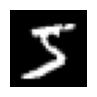

epoch = 0:i = 9:loss = tensor(2.2852, grad_fn=<DivBackward1>):acc = 0.2643333333333333
epoch = 0:i = 19:loss = tensor(2.0131, grad_fn=<DivBackward1>):acc = 0.31311666666666665
epoch = 0:i = 29:loss = tensor(1.7297, grad_fn=<DivBackward1>):acc = 0.4811166666666667
epoch = 0:i = 39:loss = tensor(1.2530, grad_fn=<DivBackward1>):acc = 0.67305
epoch = 0:i = 49:loss = tensor(1.3896, grad_fn=<DivBackward1>):acc = 0.7469833333333333
epoch = 0:i = 59:loss = tensor(0.7171, grad_fn=<DivBackward1>):acc = 0.7764333333333333
epoch = 0:i = 69:loss = tensor(0.4891, grad_fn=<DivBackward1>):acc = 0.8263833333333334
epoch = 0:i = 79:loss = tensor(0.7423, grad_fn=<DivBackward1>):acc = 0.8381666666666666
epoch = 0:i = 89:loss = tensor(0.5394, grad_fn=<DivBackward1>):acc = 0.8499833333333333
epoch = 0:i = 99:loss = tensor(0.2978, grad_fn=<DivBackward1>):acc = 0.86045
epoch = 0:i = 109:loss = tensor(0.4134, grad_fn=<DivBackward1>):acc = 0.8835166666666666
epoch = 0:i = 119:loss = tensor(0.3767, grad_fn=<DivB

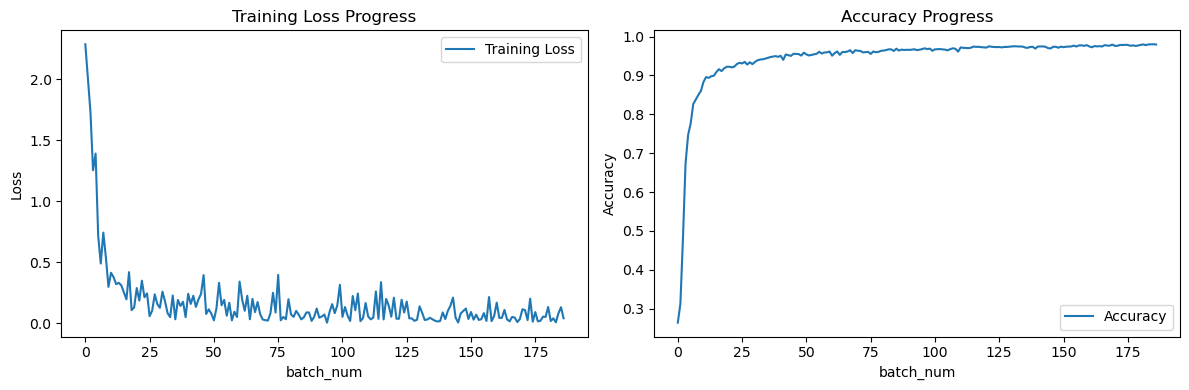

epoch = 1:i = 9:loss = tensor(0.2295, grad_fn=<DivBackward1>):acc = 0.9772666666666666
epoch = 1:i = 19:loss = tensor(0.2227, grad_fn=<DivBackward1>):acc = 0.97665
epoch = 1:i = 29:loss = tensor(0.0316, grad_fn=<DivBackward1>):acc = 0.9761333333333333
epoch = 1:i = 39:loss = tensor(0.0258, grad_fn=<DivBackward1>):acc = 0.9779833333333333
epoch = 1:i = 49:loss = tensor(0.0056, grad_fn=<DivBackward1>):acc = 0.9796
epoch = 1:i = 59:loss = tensor(0.0200, grad_fn=<DivBackward1>):acc = 0.9779833333333333
epoch = 1:i = 69:loss = tensor(0.2440, grad_fn=<DivBackward1>):acc = 0.9790666666666666
epoch = 1:i = 79:loss = tensor(0.0574, grad_fn=<DivBackward1>):acc = 0.9785166666666667
epoch = 1:i = 89:loss = tensor(0.0641, grad_fn=<DivBackward1>):acc = 0.9785333333333334
epoch = 1:i = 99:loss = tensor(0.0067, grad_fn=<DivBackward1>):acc = 0.9760833333333333
epoch = 1:i = 109:loss = tensor(0.1398, grad_fn=<DivBackward1>):acc = 0.9783833333333334
epoch = 1:i = 119:loss = tensor(0.2209, grad_fn=<DivBac

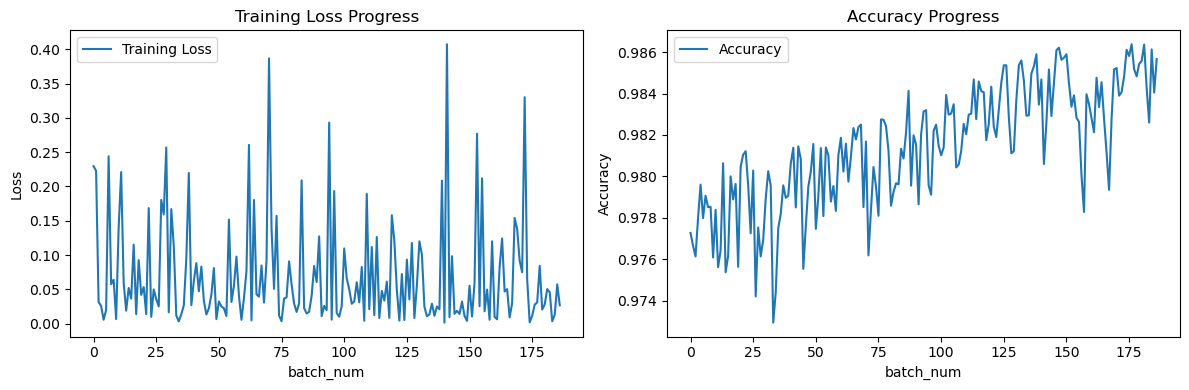

In [125]:
model = train('./',device='cpu')